# Import

In [1]:
%load_ext nb_black
import cooler
import numpy as np
import pandas as pd
from sklearn.utils.validation import check_symmetric
import os
import matplotlib.pyplot as plt
import seaborn as sns

<IPython.core.display.Javascript object>

In [2]:
from topology_loop_caller.plotting import plot_hic_matrix_fragment, genomic_dist_interaction_freq_plot
from topology_loop_caller.distance_transform import negative_log_transformation, pearson_distance
from topology_loop_caller.matrix_operations import load_cooler, transform_and_save_matrix
from topology_loop_caller.utils import list_full_paths

<IPython.core.display.Javascript object>

# Load data

In [3]:
nonbal = load_cooler("../data/data_new/0A_2000_down.cool", balance_matrix=False)
bal = load_cooler("../data/data_new/0A_2000_down.cool", balance_matrix=True)

2023-03-04 20:07:35.227 | SUCCESS  | topology_loop_caller.matrix_operations:load_cooler:31 - Loaded given .cool file 0A_2000_down.cool.
2023-03-04 20:07:36.491 | INFO     | topology_loop_caller.utils:timeit_wrapper:20 - Function load_cooler took 1.2919 seconds.
2023-03-04 20:07:36.500 | SUCCESS  | topology_loop_caller.matrix_operations:load_cooler:31 - Loaded given .cool file 0A_2000_down.cool.
2023-03-04 20:07:38.547 | INFO     | topology_loop_caller.utils:timeit_wrapper:20 - Function load_cooler took 2.0546 seconds.


<IPython.core.display.Javascript object>

In [4]:
bal.shape, nonbal.shape

((17174, 17174), (17174, 17174))

<IPython.core.display.Javascript object>

In [5]:
bal.dtype

dtype('float64')

<IPython.core.display.Javascript object>

# Hi-C matrix visualisation


<AxesSubplot:title={'center':'Nonbalanced heatmap Fragment'}>

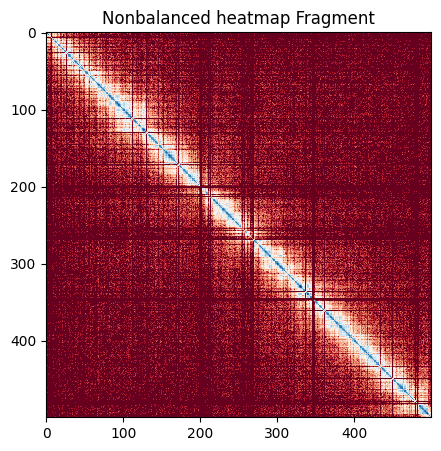

<IPython.core.display.Javascript object>

In [6]:
plot_hic_matrix_fragment(
    nonbal, (1000, 1000, 500), figsize=(5, 5), plot_title="Nonbalanced heatmap Fragment"
)

<AxesSubplot:title={'center':'Balanced heatmap Fragment'}>

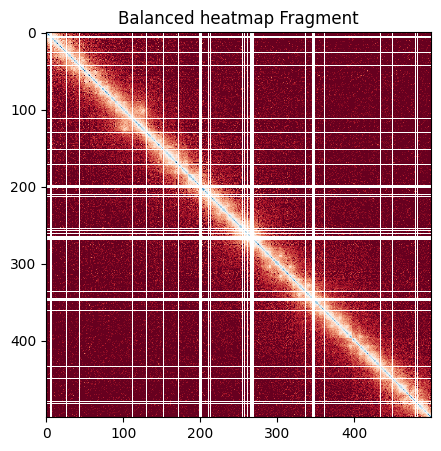

<IPython.core.display.Javascript object>

In [7]:
plot_hic_matrix_fragment(
    bal,
    (1000, 1000, 500),
    lop1p_add=1e-3,
    figsize=(5, 5),
    plot_title="Balanced heatmap Fragment",
)

<AxesSubplot:title={'center':'Balanced heatmap'}>

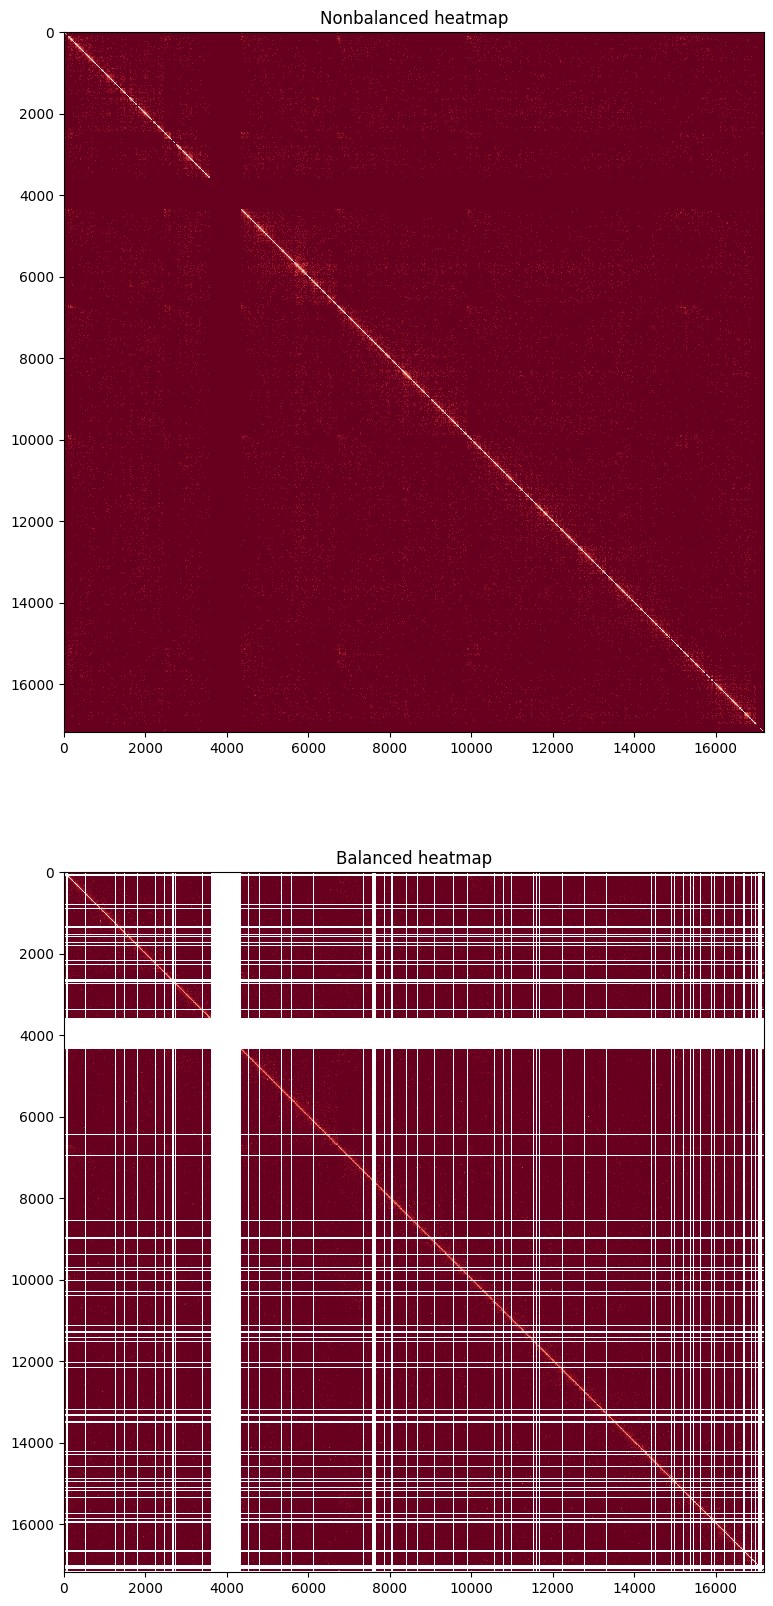

<IPython.core.display.Javascript object>

In [8]:
fig, axs = plt.subplots(2, figsize = (10, 20))
plot_hic_matrix_fragment(
    nonbal, subset=None, ax=axs[0],
    plot_title="Nonbalanced heatmap",
)
plot_hic_matrix_fragment(
    bal,  subset=None, ax=axs[1],
    lop1p_add=1e-3,
    plot_title="Balanced heatmap",
)


We see a lot of rows, that became NaNs, due to the part of cooler normalization procedure - blacklisting:<br> --min-nnz (Ignore bins from the contact matrix whose marginal number of nonzeros is less than this number. [default: 10])<br>
So we have to take it into account later.

<AxesSubplot:>

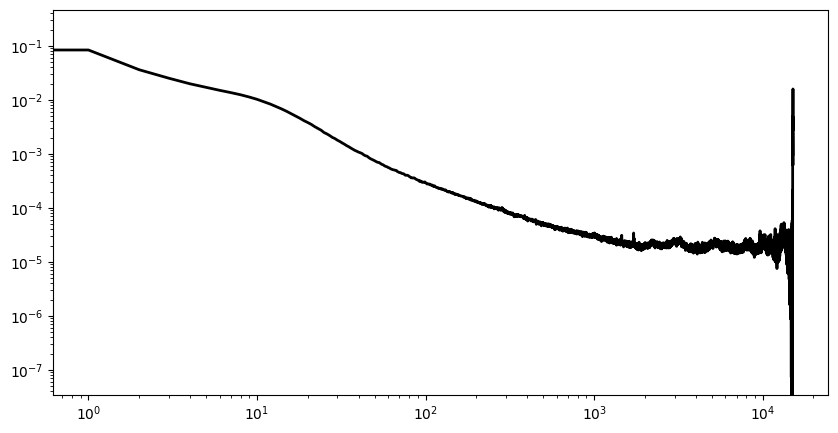

<IPython.core.display.Javascript object>

In [9]:
genomic_dist_interaction_freq_plot(bal, figsize=(10,5), color='black')

# Contact map to distance matrix

We have to remember, that our function does not output Euclidian distances per se, because the obtained distances won't obey triangle inequality (|a| + |b| ≥ |a + b|). But our output is useful for subsequent Topological Data Analysis and could be seen as some kind of similarity function, therefore in the following sections we will still use the term "Distance" for the description of that output.

## prev. iteration

In [10]:
log_dist_matrix = negative_log_transformation(bal)

2023-03-04 20:08:34.232 | INFO     | topology_loop_caller.utils:timeit_wrapper:20 - Function negative_log_transformation took 23.2942 seconds.


<IPython.core.display.Javascript object>

## current iteration

In [11]:
pearson_dist_matrix = pearson_distance(bal)

2023-03-04 20:09:33.114 | INFO     | topology_loop_caller.utils:timeit_wrapper:20 - Function pearson_distance took 58.8742 seconds.


<IPython.core.display.Javascript object>

## testing

In [12]:
print(log_dist_matrix.min(), log_dist_matrix.max())
print(pearson_dist_matrix.min(), pearson_dist_matrix.max())

0.0 0.9999668193237654
0.0 1.0033227360715051


<IPython.core.display.Javascript object>

In [13]:
_ = check_symmetric(log_dist_matrix, tol=1e-20)
_ = check_symmetric(pearson_dist_matrix, tol=1e-20)

<IPython.core.display.Javascript object>

In [14]:
ind = np.isnan(bal).all(axis=1)
no_nan_matrix = bal[~ind][:, ~ind]

<IPython.core.display.Javascript object>

<AxesSubplot:title={'center':'Logarithm Distance Map Fragment'}>

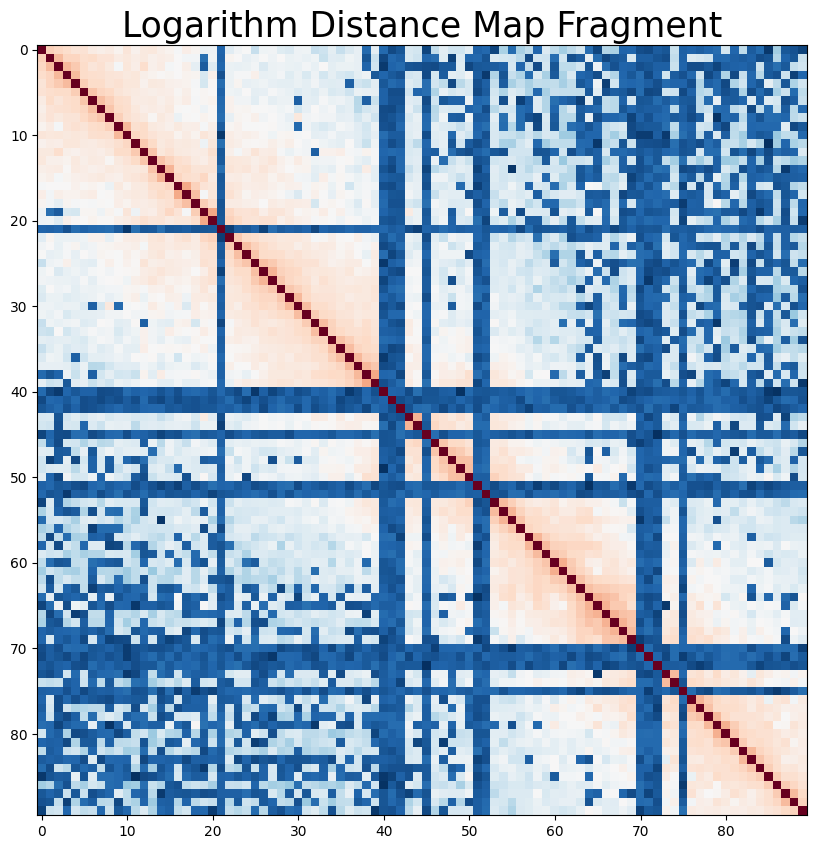

<IPython.core.display.Javascript object>

In [15]:
plot_hic_matrix_fragment(
    log_dist_matrix, (935, 935, 90), figsize=(10, 10), log_scaled=False,plot_title="Logarithm Distance Map Fragment", title_fontsize=25
)

<AxesSubplot:title={'center':'Pearson Distance Map Fragment'}>

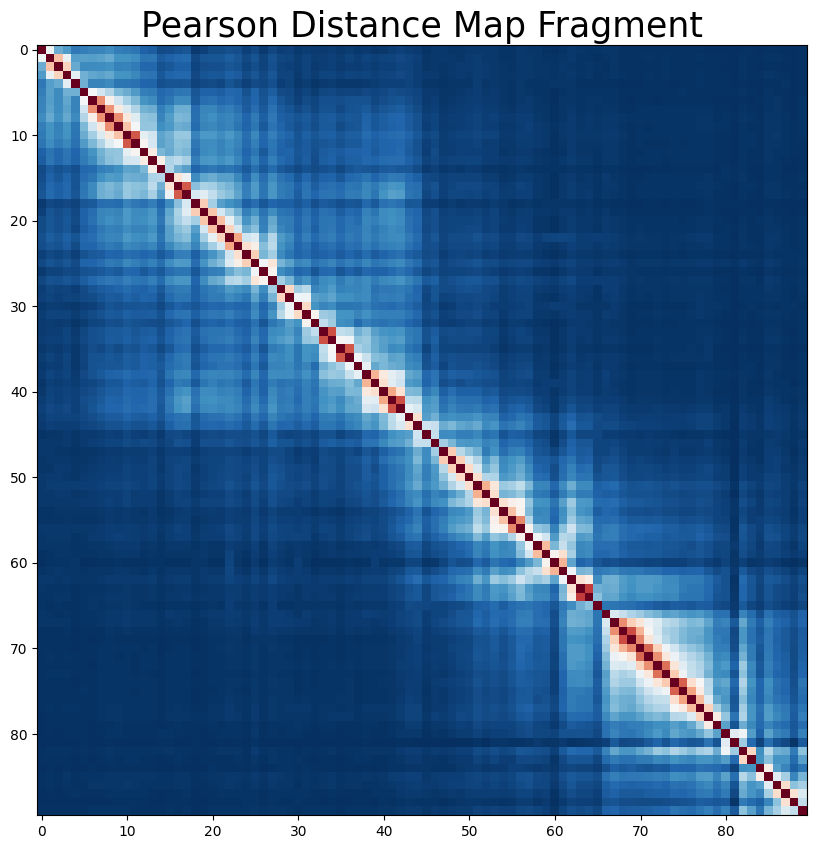

<IPython.core.display.Javascript object>

In [16]:
plot_hic_matrix_fragment(
    pearson_dist_matrix, (935, 935, 90), figsize=(10, 10), log_scaled=False,plot_title="Pearson Distance Map Fragment", title_fontsize=25
)

<AxesSubplot:title={'center':'Contact Map Fragment, log scale'}>

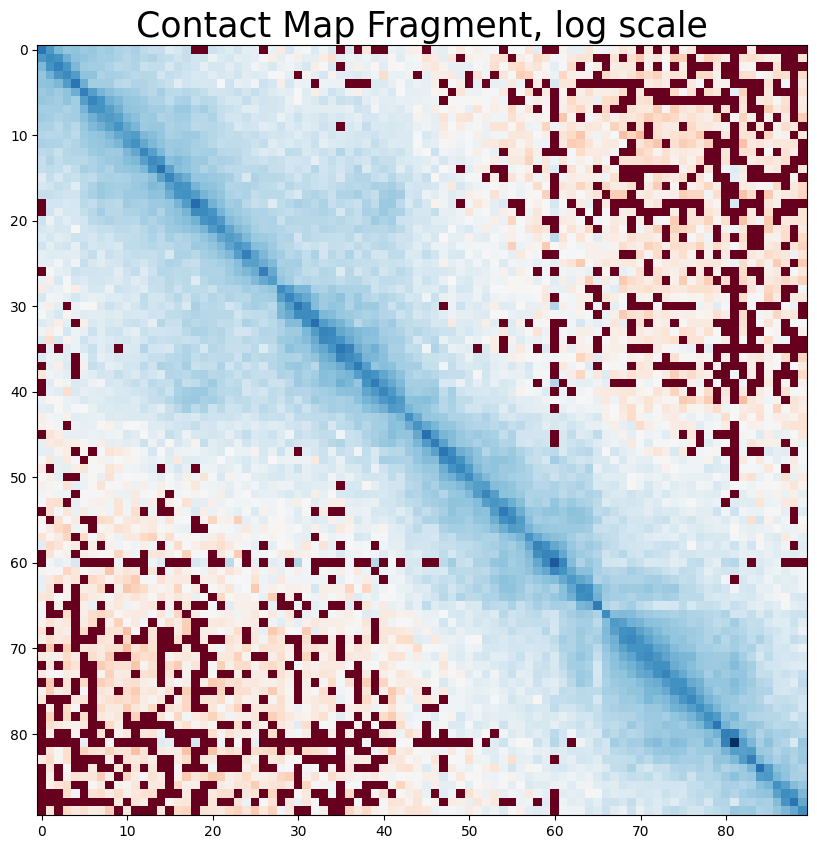

<IPython.core.display.Javascript object>

In [17]:
plot_hic_matrix_fragment(
    no_nan_matrix, (935, 935, 90), figsize=(10, 10), log_scaled=True,lop1p_add=1e-6,plot_title="Contact Map Fragment, log scale", title_fontsize=25)

<AxesSubplot:title={'center':'Distance Map Fragment'}>

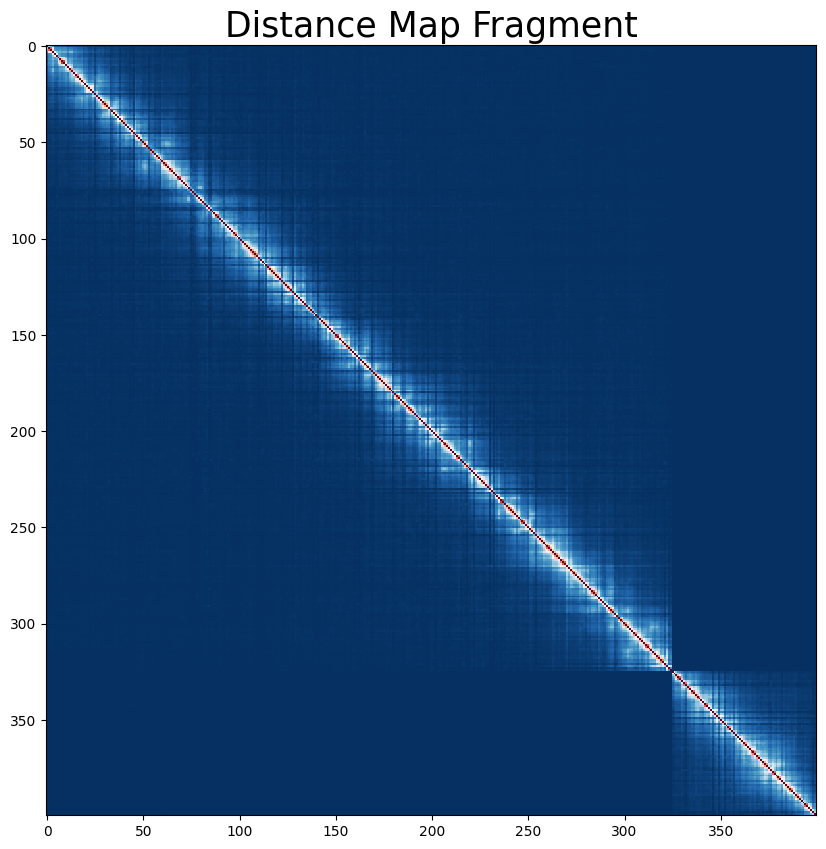

<IPython.core.display.Javascript object>

In [18]:
plot_hic_matrix_fragment(
    pearson_dist_matrix, (1900, 1900, 400), figsize=(10, 10), log_scaled=False,plot_title="Distance Map Fragment", title_fontsize=25
)

<AxesSubplot:title={'center':'Contact Map Fragment, log scale'}>

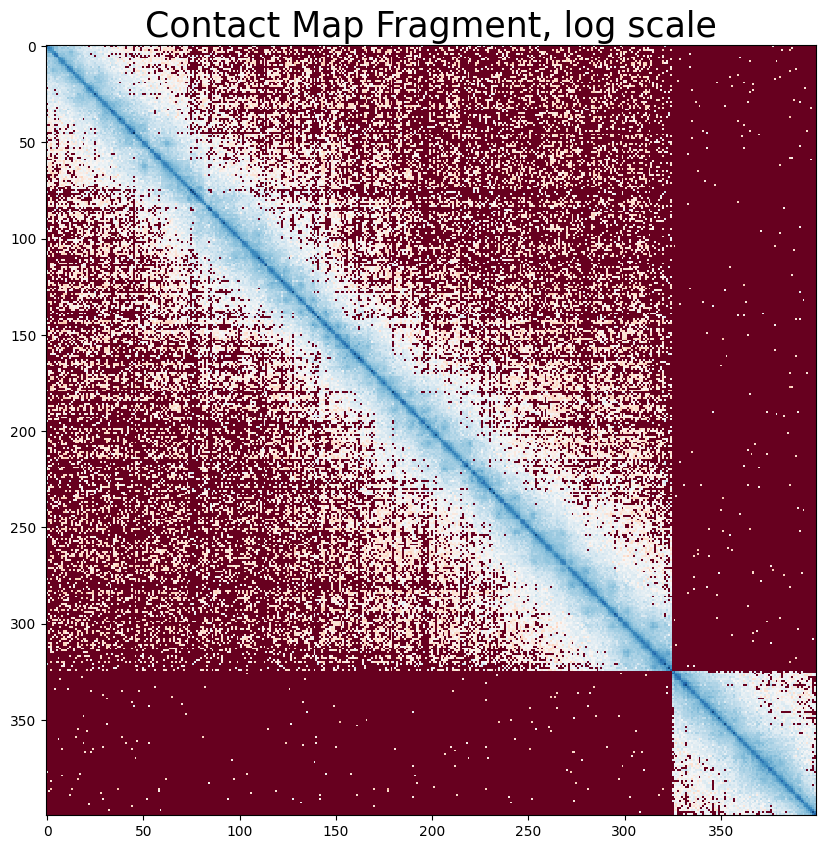

<IPython.core.display.Javascript object>

In [19]:
plot_hic_matrix_fragment(
    no_nan_matrix, (1900, 1900, 400), figsize=(10, 10), log_scaled=True, lop1p_add=1e-6,plot_title="Contact Map Fragment, log scale", title_fontsize=25)

Most of the values in the distance matrix are close to 1, having a minimall Pearson correlation between each other. The distribution of all the values < 1:

In [20]:
pearson_dist_matrix_flat = pearson_dist_matrix.flatten()
log_dist_matrix_flat = log_dist_matrix.flatten()

<IPython.core.display.Javascript object>

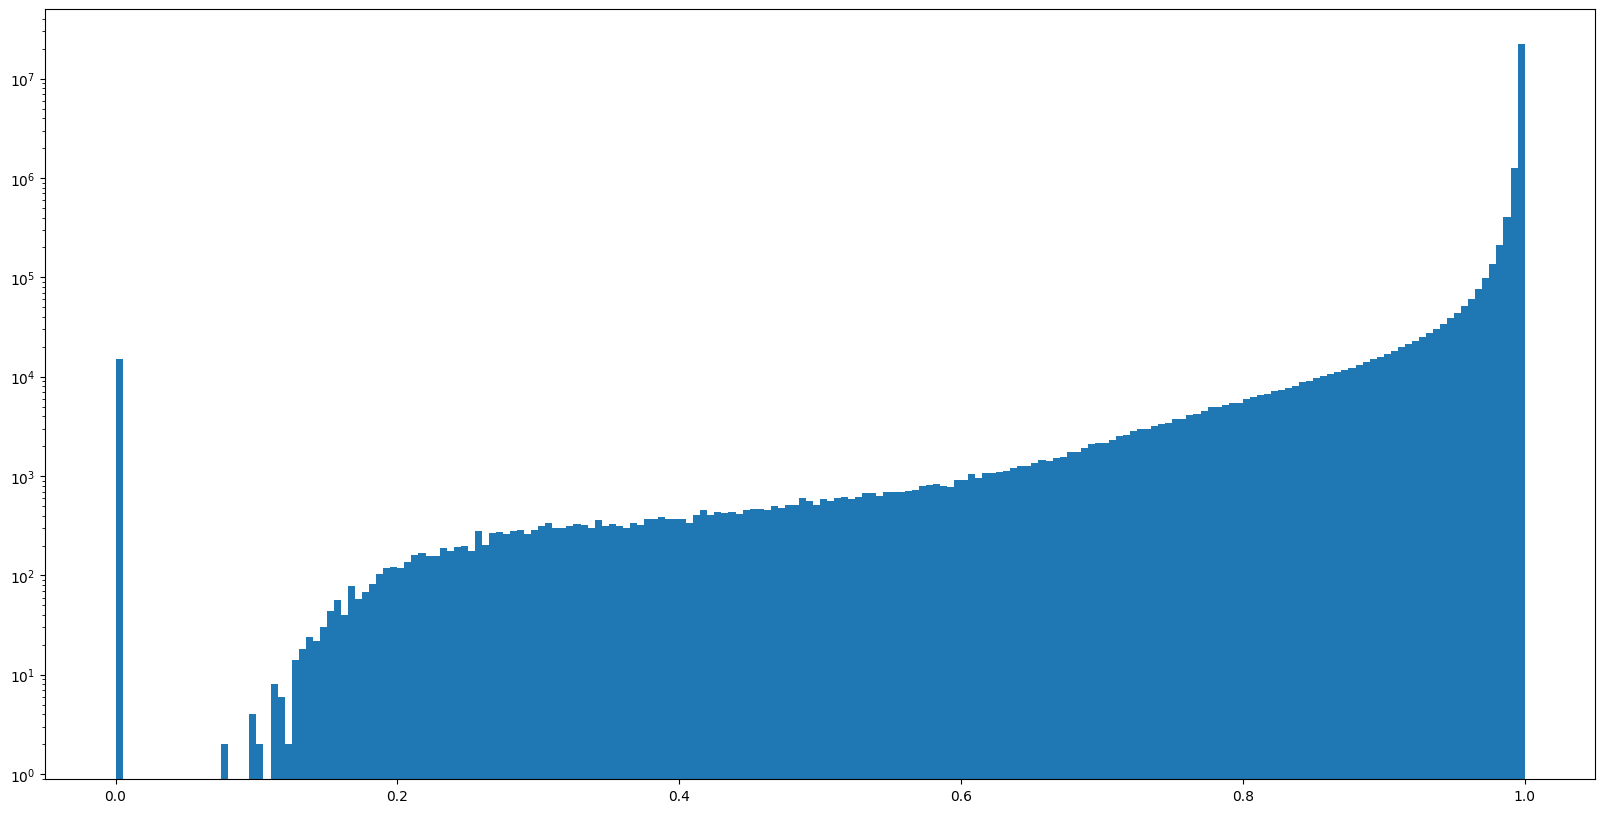

<IPython.core.display.Javascript object>

In [21]:
plt.figure(figsize = (20, 10))
plt.hist(pearson_dist_matrix_flat[pearson_dist_matrix_flat < 1.0], bins = 200)
plt.yscale('log')

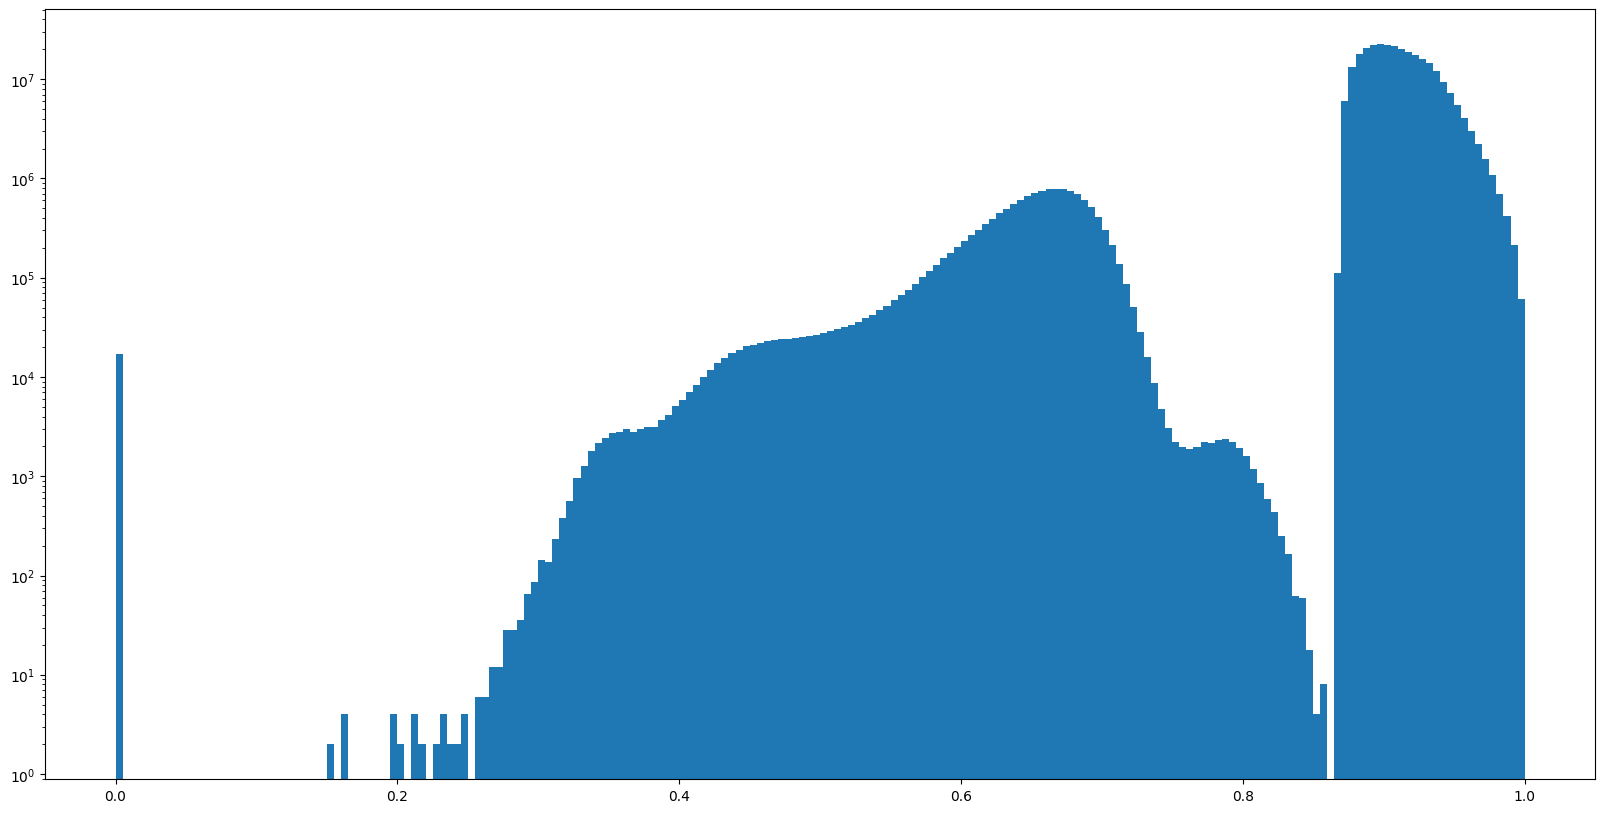

<IPython.core.display.Javascript object>

In [22]:
plt.figure(figsize = (20, 10))
plt.hist(log_dist_matrix_flat[log_dist_matrix_flat < 1.0], bins = 200)
plt.yscale('log')

Person distance matrix outputs more interpretable results: distance distribution is logical, loop patterns (dots) are preserved. We are mostly interested in the distances < 0.5 because of our maxrad = 0.5 parameter in the Eirene command.

# Data processing

In [23]:
input_file_paths = list_full_paths("../data/data_new")

<IPython.core.display.Javascript object>

In [49]:
for name in input_file_paths:
    replica_name = name.split('/')[-1].split('_')[0]
    bal = load_cooler(name, balance_matrix=True)
    transform_and_save_matrix(bal,
                              saved_file_prefix=replica_name,
                              saved_file_base_folder="../results/NoNAN_DM_new/",
                              save_preserved_idx=True,
                              preserved_idx_folder= "../results/DM_indices/",
                              distance_function= "pearson",
                              sqrt=True)

2023-03-04 18:35:31.359 | SUCCESS  | topology_loop_caller.matrix_operations:load_cooler:31 - Loaded given .cool file 0A_2000_down.cool.
2023-03-04 18:35:33.451 | INFO     | topology_loop_caller.utils:timeit_wrapper:20 - Function load_cooler took 2.1048 seconds.
2023-03-04 18:35:33.796 | SUCCESS  | topology_loop_caller.matrix_operations:transform_and_save_matrix:101 - 0A_saved.npy is saved
2023-03-04 18:35:33.799 | SUCCESS  | topology_loop_caller.matrix_operations:transform_and_save_matrix:104 - 0A_deleted.npy is saved
2023-03-04 18:36:32.103 | INFO     | topology_loop_caller.utils:timeit_wrapper:20 - Function pearson_distance took 58.3027 seconds.
2023-03-04 18:36:36.435 | SUCCESS  | topology_loop_caller.matrix_operations:transform_and_save_matrix:120 - 0A.npy is transformed with pearson method and saved.
2023-03-04 18:36:36.436 | INFO     | topology_loop_caller.utils:timeit_wrapper:20 - Function transform_and_save_matrix took 62.9777 seconds.
2023-03-04 18:36:36.447 | SUCCESS  | topol

<IPython.core.display.Javascript object>

# Result verification

Making sure that the output distance matrices are quadratic and that the amounts of saved and deleted bins sum up to 17174:

In [25]:
for name in input_file_paths:
    replica_name = name.split('/')[-1].split('_')[0]
    saved_bins = np.load(f'../results/DM_indices/{replica_name}_saved.npy')
    deleted_bins = np.load(f'../results/DM_indices/{replica_name}_deleted.npy')
    dist_matrix = np.load(f'../results/NoNAN_DM_new/{replica_name}.npy')
    print(saved_bins.shape, deleted_bins.shape, dist_matrix.shape)

(15122,) (2052,) (15122, 15122)
(15148,) (2026,) (15148, 15148)
(15386,) (1788,) (15386, 15386)
(15365,) (1809,) (15365, 15365)
(15333,) (1841,) (15333, 15333)
(15311,) (1863,) (15311, 15311)
(15288,) (1886,) (15288, 15288)
(15287,) (1887,) (15287, 15287)


<IPython.core.display.Javascript object>